<a href="https://colab.research.google.com/github/seeedata/Kaggle_Study/blob/main/231010%20digit%20recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MNIST-digit recognizer
https://www.kaggle.com/code/tawfikelmetwally/mnist-digit-recognizer-99-38-accuracy/notebook

#Preparing Data

##1 - reading and exploring data

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(os.listdir('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/3주차'))

['train.csv', 'sample_submission.csv', 'test.csv', 'digit recognizer.ipynb']


In [3]:
train = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/3주차/train.csv')
test = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/3주차/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/3주차/sample_submission.csv')

print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [4]:
print(train.head(1))
print('\n', test.head(1))

   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  

[1 rows x 785 columns]

    pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0       0       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  

[1 rows x 784 columns]


In [5]:
#put labels into y_train
y_train = train['label']

#drop 'label' column
X_train = train.drop('label', axis=1)

X_train.shape, y_train.shape

((42000, 784), (42000,))

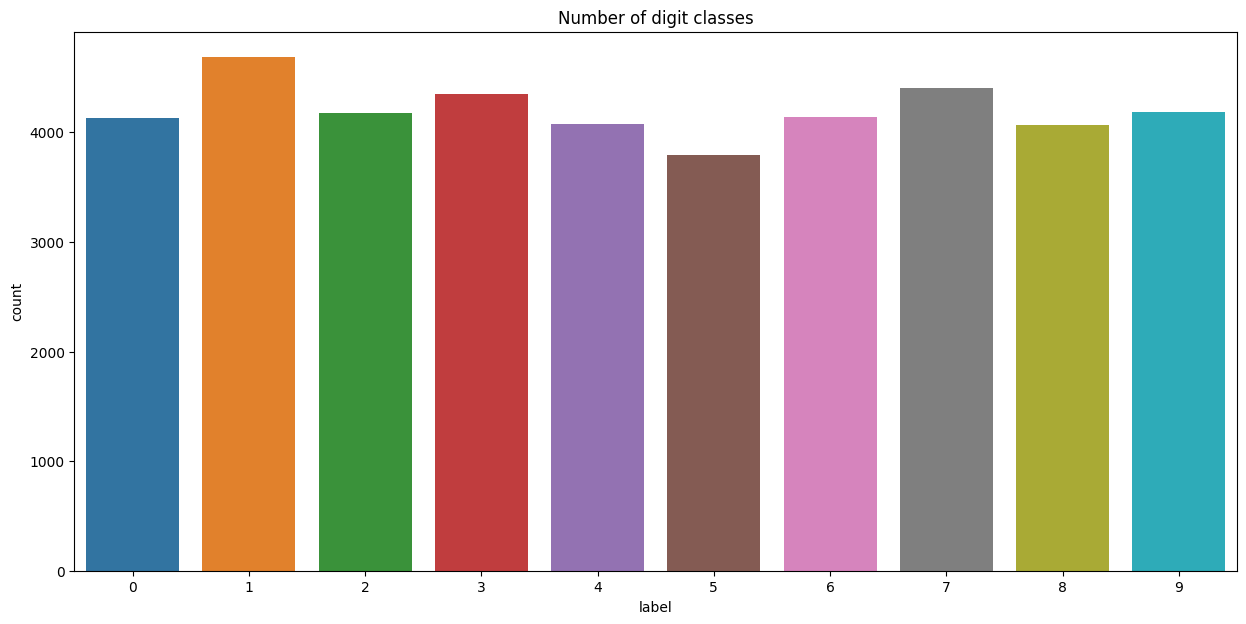

In [6]:
#visualize number of digits classes
plt.figure(figsize=(15,7))
sns.countplot(x='label', data=train)
plt.title('Number of digit classes');  #;: plt.show()

All classes are almost balanced.

##2 - Ploting a sample

Note that we choose the shape of images 28 x 28 because the dataframe contains 784 which means 28 x 28.

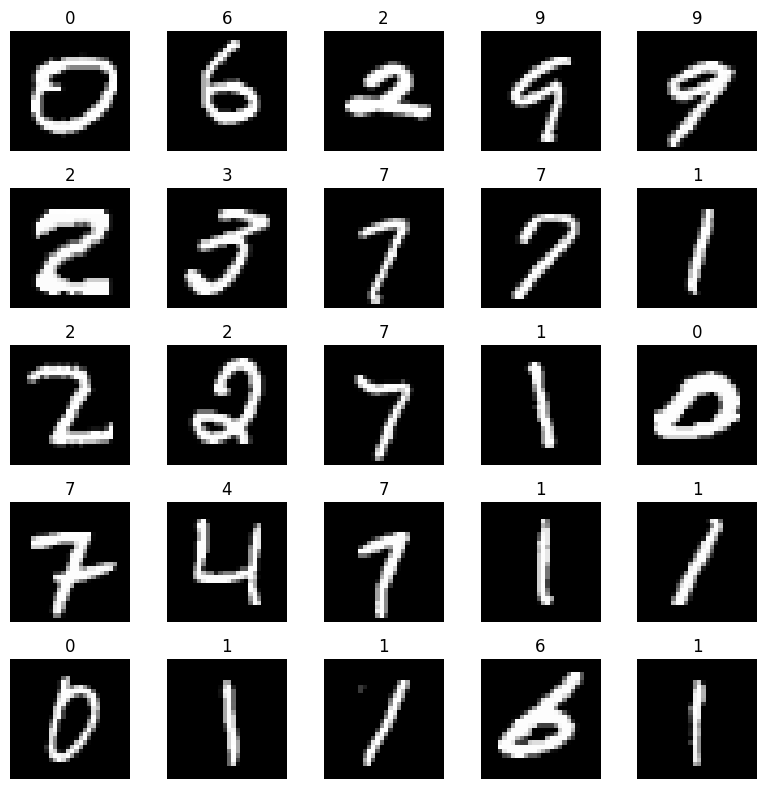

In [7]:
#sample 25 images
np.random.seed(42)
random_indices = np.random.randint(0, 42000, 25)

images = []
labels = []
for i in random_indices:
    img = X_train.iloc[i].to_numpy()
    img = img.reshape((28, 28, 1))  #1: 흑백 이미지
    images.append(img)
    label = y_train[i]
    labels.append(label)

#plot the images
plt.subplots(figsize=(8,8))
for i, image in enumerate(images):
    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(labels[i])
    plt.axis('off')  #축을 없앰
plt.tight_layout()
plt.show()

## 3 - Normalization, Reshape and Label Encoding

- Normalization
     - We perform a grayscale normalization to reduce the effect of illumination's differences.
     - If we perform normalization, CNN works faster.

- Reshape
    - Train and test images (28 x 28)
    - We reshape all data to 28 x 28 x 1 3D matrices.
    - Keras needs and extra dimension in the end which corresponds to channels. Our images are gray scaled so it use only one channel.

- Label Encoding
    - Encode labels to one hot vectors
    
    2 => [0,0,1,0,0,0,0,0,0,0]

    4 => [0,0,0,0,1,0,0,0,0,0]


**grayscale normalization**

각 이미지의 픽셀 값은 일반적으로 0(검은색)부터 255(흰색)까지의 범위를 가진다. 모든 이미지 데이터를 255.0으로 나눠, 픽셀 값의 범위를 0에서 1 사이의 값으로 정규화하면, 이미지의 밝기 값이 일정 범위 내로 조정된다.

In [8]:
#normalize the data
X_train = X_train / 255.0
test = test / 255.0

#label encoding
y_train = to_categorical(y_train, num_classes=10)

#reshape
X_train = X_train.values.reshape(-1, 28, 28, 1)
#변경된 배열의 '-1' 위치의 차원은 "원래 배열의 길이와 남은 차원으로부터 추정"이 된다.
test = test.values.reshape(-1, 28, 28, 1)
print('X_train shape: ', X_train.shape)
print('test shape: ', test.shape)

X_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


##4 - Splitting the data

We split the data into train and val sets.
- val size is 20%.
- train size is 80%.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(33600, 28, 28, 1) (33600, 10)
(8400, 28, 28, 1) (8400, 10)


#Data Augmentation
to avoid overfitting problem

In [10]:
datagen = ImageDataGenerator(
    #이미지 밝기 조절
    #이미지의 픽셀 값에서 평균 값을 빼서 이미지를 중앙 정렬
    #전체 데이터셋의 평균을 기준으로 정렬
    featurewise_center = False,
    #각 이미지에 대해 해당 이미지의 픽셀 값에서 평균 값을 빼서 이미지를 중앙 정렬
    #각 이미지를 개별적으로 중앙 정렬
    samplewise_center = False,

    #이미지 대비 조절
    #이미지의 각 픽셀 값을 전체 데이터셋에서 계산한 평균, 표준편차로 정규화
    #전체 데이터셋의 픽셀 값 분포를 기준으로 정규화
    featurewise_std_normalization = False,
    #각 이미지에 대해 해당 이미지의 픽셀 값을 이미지 자체의 평균, 표준편차로 정규화
    #각 이미지를 개별적으로 정규화
    samplewise_std_normalization = False,

    #이미지를 무작위로 회전시키는 범위. 최대 20도까지 무작위 회전
    rotation_range = 20,
    #이미지를 무작위로 확대 또는 축소하는 범위
    zoom_range = 0.2,
    #이미지를 수평 또는 수직으로 무작위로 이동하는 범위
    width_shift_range = 0.2,
    height_shift_range = 0.2,

    #이미지를 수평 또는 수직으로 무작위로 뒤집기
    horizontal_flip = False,
    vertical_flip = False)

#이미지 데이터를 mini-batch 형태로 생성
train_gen = datagen.flow(X_train, y_train, batch_size=128)
val_gen = datagen.flow(X_val, y_val, batch_size=128)

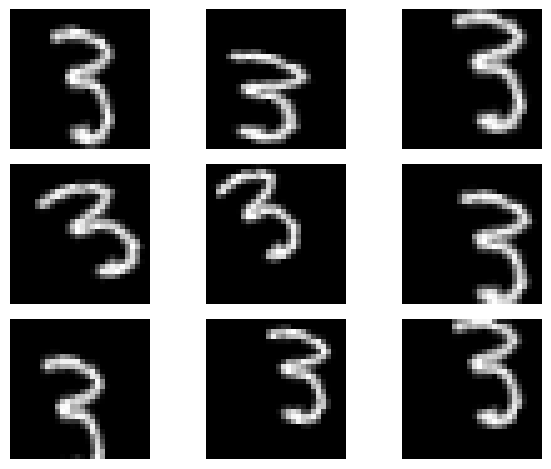

In [11]:
img = X_train[2].reshape((1, 28, 28, 1))

for i, batch in enumerate(datagen.flow(img, batch_size=1)):
    plt.subplot(3, 3, i+1)
    plt.imshow(batch[0], cmap='gray')
    plt.axis('off')

    if i == 8: break

plt.tight_layout()
plt.show()

#modeling

In [12]:
def model():
    model = Sequential([

    Conv2D(64, kernel_size=(3,3), padding='Same', activation='relu', input_shape=(28,28,1)),
    Conv2D(64, kernel_size=(3,3), padding='Same', activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3,3), padding='Same', activation='relu'),
    Conv2D(128, kernel_size=(3,3), padding='Same', activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
    ])

    return model

model_1 = model()
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 128)       1

In [13]:
optimizer = Adam(learning_rate = 0.001)

model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
#정확도가 개선되지 않을 때 학습률이 줄어든다.
#학습률이 너무 높아서 수렴하지 않는 상황이나, 정확도 향상이 미미한 경우에 모델의 학습을 안정화시키고 빠르게 수렴하도록 도와준다.
learning_rate_reduction = ReduceLROnPlateau(
    #val set의 정확도를 기준으로 학습률 조절
    monitor='val_accuracy',
    #val_accuracy가 3 epoch 동안 향상되지 않으면 학습률 조절
    patience=3,
    #상세 정보 출력
    verbose=1,
    #학습률을 반으로 줄이며 조절
    factor=0.5,
    #학습률이 조절될 때의 최소값
    min_lr=0.00001)

#모델의 훈련을 조기 종료 -> 과적합 방지
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1,
    #val_accuracy를 최대화하는 방향으로 모니터링. 정확도가 개선될 때마다 훈련을 계속함.
    mode='max',
    #조기 종료가 발생했을 때, 가장 성능이 좋았던 에포크의 가중치를 모델에 복원
    #최상의 모델 가중치를 유지하면서 훈련을 조기 종료할 수 있음
    #훈련 중에 발생한 과적합을 방지하면서도 최상의 모델을 얻을 수 있도록 도와줌
    restore_best_weights=True)

In [15]:
#fit the model
history = model_1.fit_generator(
    train_gen,
    epochs = 20,
    #각 epoch에서 mini-batch의 수. 전체 데이터를 mini-batch 크기로 나눈 결과
    steps_per_epoch = X_train.shape[0] // 128,
    validation_data = val_gen,
    validation_steps = X_val.shape[0] // 128,
    callbacks = [learning_rate_reduction, early_stopping],
    verbose = 2
)

Epoch 1/20
262/262 - 25s - loss: 0.4695 - accuracy: 0.8522 - val_loss: 2.6264 - val_accuracy: 0.3572 - lr: 0.0010 - 25s/epoch - 97ms/step
Epoch 2/20
262/262 - 16s - loss: 0.1525 - accuracy: 0.9540 - val_loss: 0.2752 - val_accuracy: 0.9168 - lr: 0.0010 - 16s/epoch - 60ms/step
Epoch 3/20
262/262 - 12s - loss: 0.1080 - accuracy: 0.9676 - val_loss: 0.0928 - val_accuracy: 0.9707 - lr: 0.0010 - 12s/epoch - 47ms/step
Epoch 4/20
262/262 - 12s - loss: 0.0898 - accuracy: 0.9749 - val_loss: 0.0873 - val_accuracy: 0.9738 - lr: 0.0010 - 12s/epoch - 47ms/step
Epoch 5/20
262/262 - 13s - loss: 0.0823 - accuracy: 0.9761 - val_loss: 0.0745 - val_accuracy: 0.9778 - lr: 0.0010 - 13s/epoch - 48ms/step
Epoch 6/20
262/262 - 12s - loss: 0.0713 - accuracy: 0.9791 - val_loss: 0.0640 - val_accuracy: 0.9796 - lr: 0.0010 - 12s/epoch - 47ms/step
Epoch 7/20
262/262 - 12s - loss: 0.0658 - accuracy: 0.9810 - val_loss: 0.0489 - val_accuracy: 0.9846 - lr: 0.0010 - 12s/epoch - 47ms/step
Epoch 8/20
262/262 - 12s - loss: 0

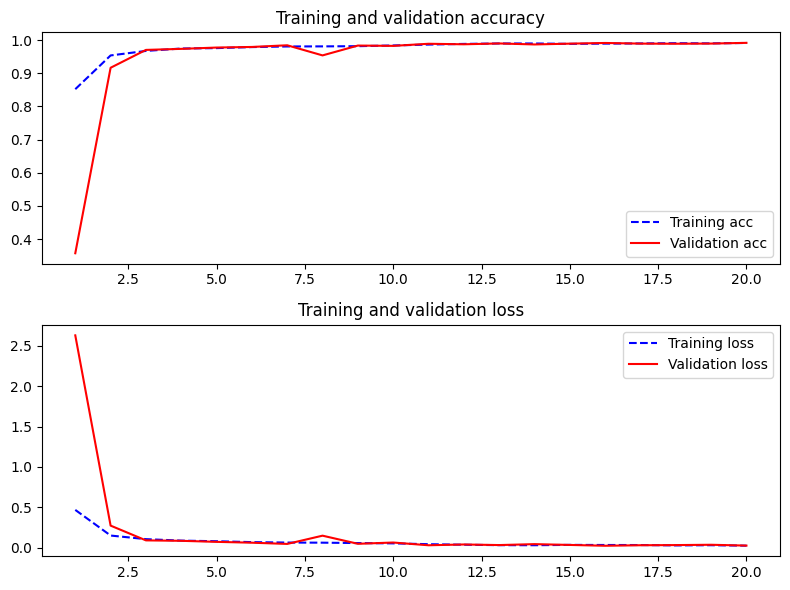

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(2, 1, figsize=(8,6))

epochs = range(1, len(acc)+1)

ax[0].plot(epochs, acc, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.tight_layout()
plt.show()

In [17]:
#evaluate the model on the training data
train_loss, train_accuracy = model_1.evaluate(X_train, y_train)

#evaluate the model on the validation data
val_loss, val_accuracy = model_1.evaluate(X_val, y_val)

print('---------------------')
print('Train loss:', round(train_loss, 4))
print('Train accuracy', round(train_accuracy, 4))
print('Val loss', round(val_loss, 4))
print('Val accuracy', round(val_accuracy, 4))

263/263 [==============================] - 1s 3ms/step - loss: 0.0229 - accuracy: 0.9939
---------------------
Train loss: 0.0106
Train accuracy 0.9968
Val loss 0.0229
Val accuracy 0.9939


In [18]:
val_predict = model_1.predict(X_val)
#확률이 가장 높은 label이 최종 label이 된다.
val_predict_labels = np.argmax(val_predict, axis=1)
val_true_labels = np.argmax(y_val, axis=1)
num_errors = np.count_nonzero(val_predict_labels != val_true_labels)

print(f'Number of error predictions: {num_errors}')

263/263 [==============================] - 1s 2ms/step
Number of error predictions: 51


In [19]:
print(f'the percentage of errors is {(num_errors / len(y_val))}')

the percentage of errors is 0.006071428571428571


#Final Submission

In [21]:
predict_x = model_1.predict(test)
class_x = np.argmax(predict_x, axis=1)

submission['Label'] = class_x
submission

875/875 [==============================] - 2s 2ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
